# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # Применение аугментаций
        self.transform = transform
        self.toTensor = transforms.ToTensor()

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):

        x = self.load_sample(self.files[index])
        x = self.transform(image=np.asarray(x))['image']
        x = self.toTensor(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        

In [16]:
from sklearn.model_selection import train_test_split
import albumentations as A


# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device("cuda")
# Batch size
BATCH_SIZE = 32

TRAIN_DIR = Path('train')
TEST_DIR = Path('testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

# Transforms
#     A.Resize(*im_size),
#     A.Rotate(),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
#     A.ColorJitter(),
#     A.RandomBrightnessContrast(),
    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ColorJitter(brightness=0.6, contrast=0.5, saturation=0.3, hue=0.03),
    A.Resize(int(RESCALE_SIZE * 1.1), int(RESCALE_SIZE * 1.1)),
    A.RandomCrop(width=RESCALE_SIZE, height=RESCALE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Rotate(limit=90),
    
#     A.ToTensor()
])

test_transform = A.Compose([
    A.Resize(RESCALE_SIZE, RESCALE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     A.ToTensor()
])

# Datasets
val_dataset = SimpsonsDataset(val_files, mode='val', transform = train_transform)
train_dataset = SimpsonsDataset(train_files, mode='train', transform = train_transform)
test_dataset = SimpsonsDataset(test_files, mode='test', transform = test_transform)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 3)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 3)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 3)


In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Давайте посмотрим на наших героев внутри датасета.

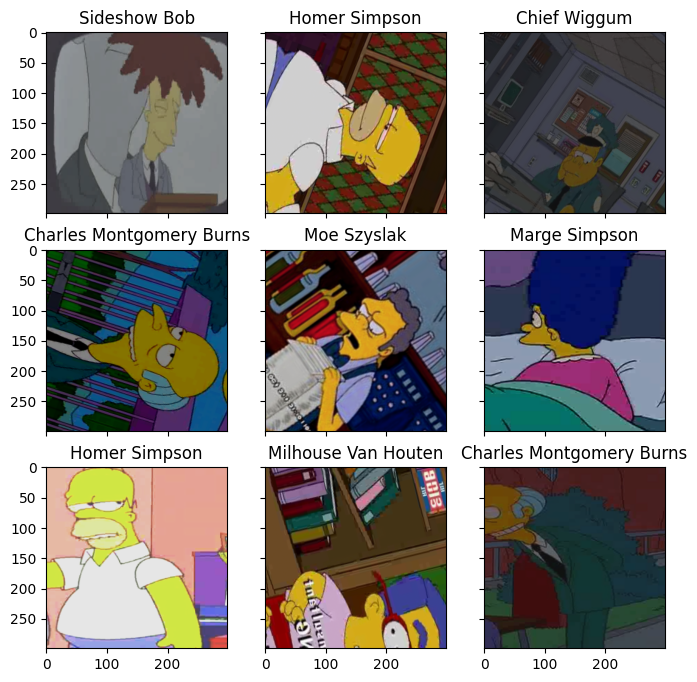

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,15699))
    im, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

## Inception

In [22]:
inception_v3_model = torchvision.models.inception_v3(pretrained=True)

In [23]:
inception_v3_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=500, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=500, out_features=42, bias=True)
)

# for param in inception_v3_model.parameters():
#     param.requires_grad = False

inception_v3_model.AuxLogits.fc = nn.Linear(768, 42)
inception_v3_model.fc = fc

inception_v3_model = inception_v3_model.to(DEVICE)

In [39]:
# for param in list(inception_v3_model.parameters())[:5]:
#     param.requires_grad = True

In [25]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    pbar = tqdm(train_loader)
  
    for inputs, labels in pbar:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [26]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    all_preds = np.array([])
    y_true = np.array([])
    

    for inputs, labels in val_loader:
        y_true = np.append(y_true, labels)
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            
            all_preds = np.append(all_preds, preds.cpu().numpy())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    
    f1 = f1_score(y_true, all_preds, average='micro')
    return val_loss, val_acc, f1

In [27]:
def train(train_loader, val_loader, model, opt, epochs, scheduler):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

#     with tqdm(desc="epoch", total=epochs) as pbar_outer:
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        scheduler.step()
#         print("loss", train_loss)

        val_loss, val_acc, f1_val = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc, f1_val))
        
        print(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                  v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
#             pbar_outer.update(1)
#             tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
#                                            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [28]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [29]:
opt = torch.optim.Adam(inception_v3_model.parameters(), lr=1e-3)
scheduler =  torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
history = train(train_dataloader, val_dataloader, model=inception_v3_model, opt=opt, epochs=30, scheduler=scheduler)

100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.42it/s]



Epoch 001 train_loss: 1.7018     val_loss 1.2226 train_acc 0.5520 val_acc 0.6804


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.39it/s]



Epoch 002 train_loss: 0.8625     val_loss 0.9954 train_acc 0.7793 val_acc 0.7562


100%|█████████████████████████████████████████| 491/491 [02:35<00:00,  3.15it/s]



Epoch 003 train_loss: 0.6425     val_loss 0.5835 train_acc 0.8305 val_acc 0.8527


100%|█████████████████████████████████████████| 491/491 [02:26<00:00,  3.36it/s]



Epoch 004 train_loss: 0.5188     val_loss 0.4957 train_acc 0.8627 val_acc 0.8745


100%|█████████████████████████████████████████| 491/491 [02:26<00:00,  3.34it/s]



Epoch 005 train_loss: 0.4526     val_loss 0.3962 train_acc 0.8779 val_acc 0.8982


100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.41it/s]



Epoch 006 train_loss: 0.3878     val_loss 0.4292 train_acc 0.8962 val_acc 0.8884


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.40it/s]



Epoch 007 train_loss: 0.3666     val_loss 0.4759 train_acc 0.9022 val_acc 0.8810


100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.42it/s]



Epoch 008 train_loss: 0.3274     val_loss 0.3522 train_acc 0.9122 val_acc 0.9112


100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.42it/s]



Epoch 009 train_loss: 0.3271     val_loss 0.3848 train_acc 0.9137 val_acc 0.8995


100%|█████████████████████████████████████████| 491/491 [02:25<00:00,  3.38it/s]



Epoch 010 train_loss: 0.2685     val_loss 0.3513 train_acc 0.9278 val_acc 0.9102


100%|█████████████████████████████████████████| 491/491 [02:26<00:00,  3.35it/s]



Epoch 011 train_loss: 0.1743     val_loss 0.1889 train_acc 0.9514 val_acc 0.9557


100%|█████████████████████████████████████████| 491/491 [02:33<00:00,  3.19it/s]



Epoch 012 train_loss: 0.1314     val_loss 0.1590 train_acc 0.9643 val_acc 0.9637


100%|█████████████████████████████████████████| 491/491 [02:35<00:00,  3.15it/s]



Epoch 013 train_loss: 0.1158     val_loss 0.1651 train_acc 0.9702 val_acc 0.9641


100%|█████████████████████████████████████████| 491/491 [02:25<00:00,  3.37it/s]



Epoch 014 train_loss: 0.1099     val_loss 0.1586 train_acc 0.9700 val_acc 0.9645


100%|█████████████████████████████████████████| 491/491 [02:26<00:00,  3.35it/s]



Epoch 015 train_loss: 0.1035     val_loss 0.1584 train_acc 0.9717 val_acc 0.9626


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.40it/s]



Epoch 016 train_loss: 0.0946     val_loss 0.1622 train_acc 0.9734 val_acc 0.9643


100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.42it/s]



Epoch 017 train_loss: 0.0886     val_loss 0.1626 train_acc 0.9752 val_acc 0.9648


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.40it/s]



Epoch 018 train_loss: 0.0817     val_loss 0.1480 train_acc 0.9786 val_acc 0.9681


100%|█████████████████████████████████████████| 491/491 [02:27<00:00,  3.32it/s]



Epoch 019 train_loss: 0.0762     val_loss 0.1518 train_acc 0.9794 val_acc 0.9685


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.40it/s]



Epoch 020 train_loss: 0.0804     val_loss 0.1475 train_acc 0.9774 val_acc 0.9689


100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.41it/s]



Epoch 021 train_loss: 0.0660     val_loss 0.1467 train_acc 0.9817 val_acc 0.9683


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.40it/s]



Epoch 022 train_loss: 0.0662     val_loss 0.1469 train_acc 0.9817 val_acc 0.9694


100%|█████████████████████████████████████████| 491/491 [02:24<00:00,  3.40it/s]



Epoch 023 train_loss: 0.0618     val_loss 0.1640 train_acc 0.9833 val_acc 0.9681


100%|█████████████████████████████████████████| 491/491 [02:23<00:00,  3.42it/s]



Epoch 024 train_loss: 0.0610     val_loss 0.1527 train_acc 0.9829 val_acc 0.9690


100%|█████████████████████████████████████████| 491/491 [02:25<00:00,  3.38it/s]



Epoch 025 train_loss: 0.0613     val_loss 0.1488 train_acc 0.9833 val_acc 0.9696


100%|█████████████████████████████████████████| 491/491 [02:27<00:00,  3.34it/s]



Epoch 026 train_loss: 0.0596     val_loss 0.1519 train_acc 0.9835 val_acc 0.9675


100%|█████████████████████████████████████████| 491/491 [02:39<00:00,  3.07it/s]



Epoch 027 train_loss: 0.0540     val_loss 0.1563 train_acc 0.9843 val_acc 0.9664


100%|█████████████████████████████████████████| 491/491 [02:40<00:00,  3.07it/s]



Epoch 028 train_loss: 0.0568     val_loss 0.1416 train_acc 0.9852 val_acc 0.9712


100%|█████████████████████████████████████████| 491/491 [02:35<00:00,  3.16it/s]



Epoch 029 train_loss: 0.0521     val_loss 0.1537 train_acc 0.9865 val_acc 0.9696


100%|█████████████████████████████████████████| 491/491 [02:26<00:00,  3.35it/s]



Epoch 030 train_loss: 0.0553     val_loss 0.1499 train_acc 0.9840 val_acc 0.9698


In [30]:
#save model
path_model = 'models/inception_v3_finetuned_all_v4.pth'
torch.save(inception_v3_model, path_model)

In [13]:
path_model = 'models/inception_v3_finetuned_all_v2.pth'
inception_v3_model = torch.load(path_model)
inception_v3_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Построим кривые обучения

In [31]:
loss, acc, val_loss, val_acc, f1_val = zip(*history)

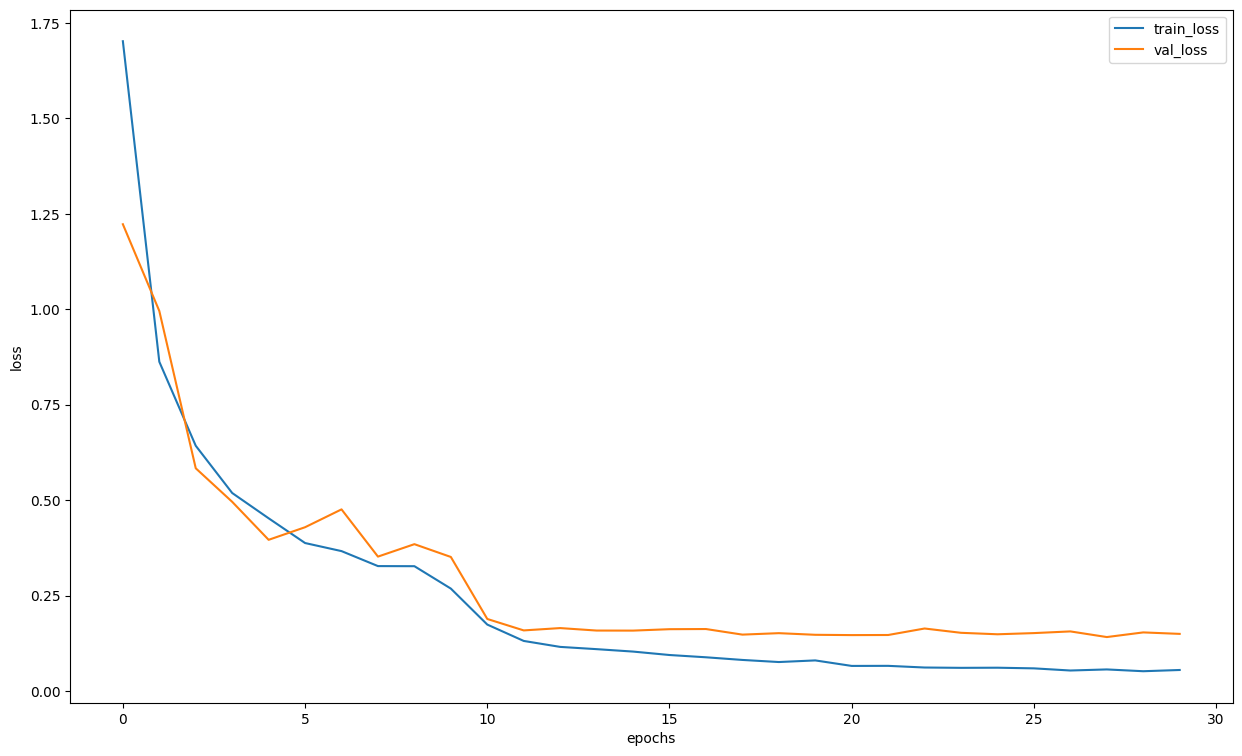

In [32]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [33]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [34]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(inception_v3_model, ex_img.unsqueeze(0))

In [35]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(inception_v3_model, imgs)

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [37]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [38]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

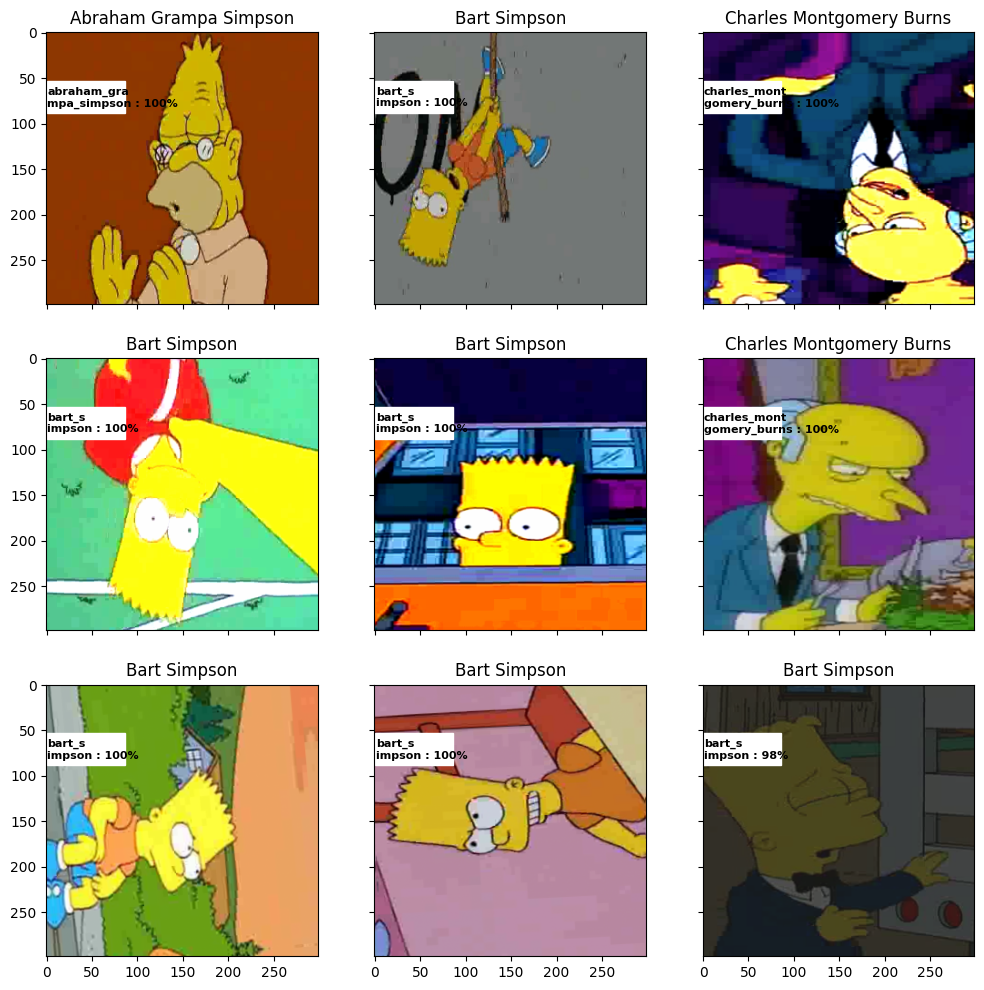

In [39]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
#     font.set_family("fantasy")
    prob_pred = predict_one_sample(inception_v3_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
plt.show()

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [40]:
def get_preds(model, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    model.eval()
    logits = []
    true_labels = []
    
    for inputs, labels in tqdm(loader):
        inputs = inputs.to(DEVICE)
        true_labels.append(labels)
        
        with torch.no_grad():          
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs, torch.cat(true_labels).numpy()

In [41]:
probs, y_true = get_preds(inception_v3_model, val_dataset)

100%|█████████████████████████████████████████| 164/164 [00:32<00:00,  5.07it/s]


In [42]:
def count_accuracy(probs, y_true):
    y_pred = np.argmax(probs, axis=1)
    correct = y_pred[y_pred == y_true]
    count_all = list(zip(*np.unique(y_true, return_counts=True)))
    
    count_correct = list(zip(*np.unique(correct, return_counts=True)))
    
    for cls in [x[0] for x in count_all]:
        
        if cls not in [x[0] for x in count_correct]:
            count_correct.insert(cls, (cls, 0))
            
    accuracy = [x[1]/y[1] for x,y  in zip(count_correct,count_all)]
    classes = [x[0] for x in count_all]
    
    return list(zip(classes, accuracy))
    

In [43]:
c_acc = count_accuracy(probs, y_true)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


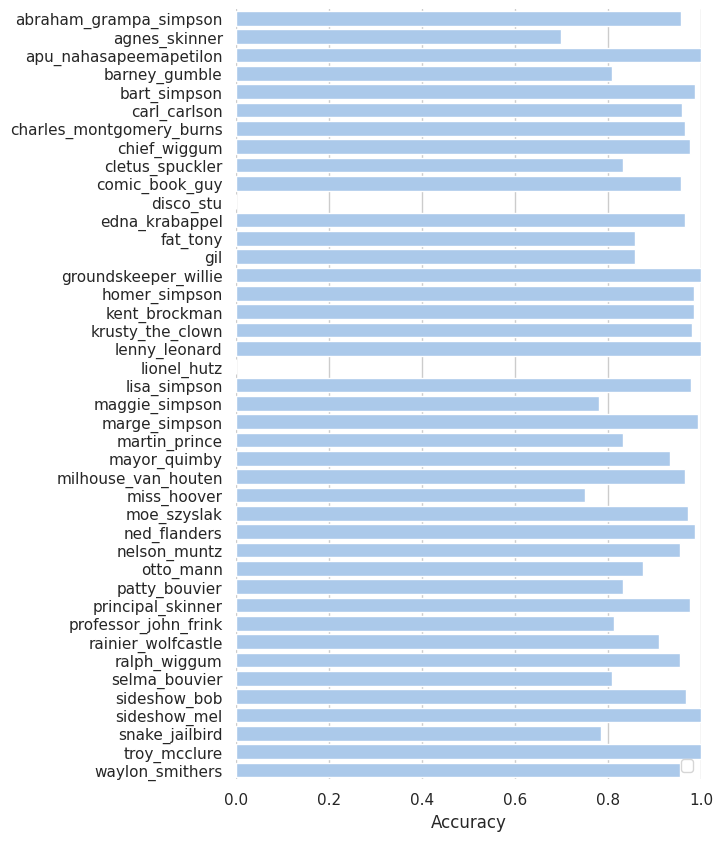

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
class_names = [label_encoder.classes_[x[0]] for x in c_acc]
classes = [x[0] for x in c_acc]
sns.barplot(x=[x[1] for x in c_acc], y=class_names, color="b", orient='h')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1), ylabel="", xlabel="Accuracy")
sns.despine(left=True, bottom=True)

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [45]:
# test_dataset = SimpsonsDataset(test_files, mode="test")
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(inception_v3_model, test_dataloader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [46]:
import pandas as pd

In [47]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [48]:
my_submit.to_csv('labels_inception_v4_finetuned_all.csv', index=False)

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
